In [1]:
from bokeh.io import show, output_notebook

output_notebook()

Loading BokehJS ...

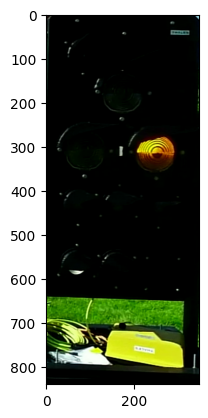

In [2]:
import skimage.io as io
import matplotlib.pyplot as plt

#own library
import signal_aspect_detection

I = io.imread("../data/drohne-signals/traffic_light0029.png")

(left,right,top,bottom) = signal_aspect_detection.crop_signal(I)

crop_img = I[top:bottom, left:right]

plt.imshow(crop_img)
plt.show()


(135, 460) (164, 489)
(221, 351) (233, 363)
(75, 347) (87, 359)
(211, 339) (243, 371)
(63, 335) (95, 368)
(128, 112) (194, 179)


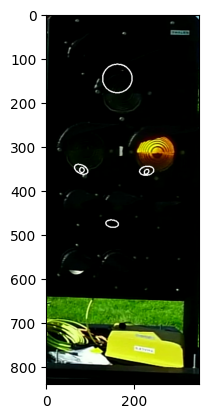

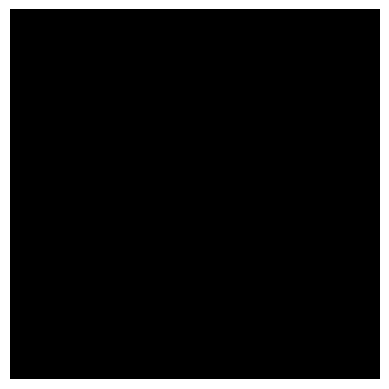

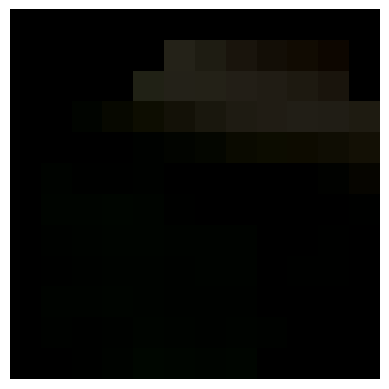

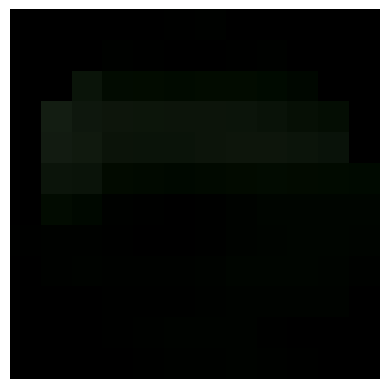

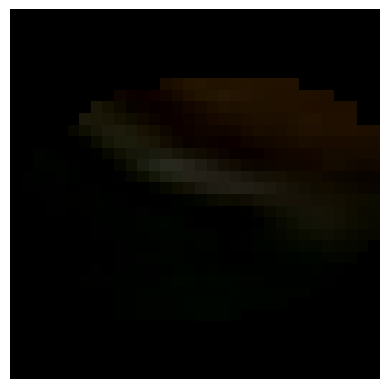

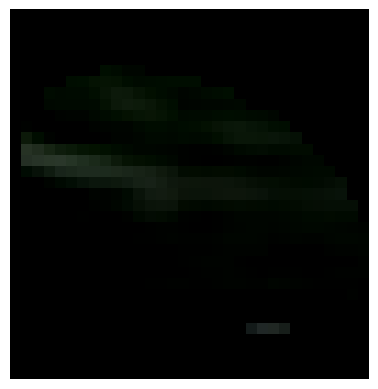

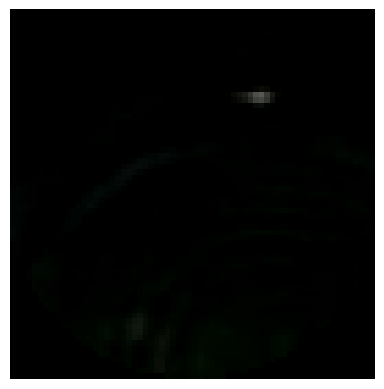

In [3]:
from bokeh.plotting import figure
import numpy as np
import skimage
import cv2



def get_lab(img):
    rows , columns, channels= img.shape
    Lv = []
    av = []
    bv = []
    for r in range(rows):   #for each column
        for c in range(columns):   
            px_color = img[r,c]
            red , green , blue = px_color[0] , px_color[1] , px_color[2] 
            L , a , b = skimage.color.rgb2lab((red,green,blue))
            Lv.append(L)
            av.append(a)
            bv.append(b)
    return Lv , av , bv
        



Iframe = np.copy(crop_img)

ellipses = [
    ((149.13394165039062, 474.87799072265625), (16.712263107299805, 28.979888916015625), 97.68181610107422),
    ((226.85122680664062, 357.22467041015625), (8.997039794921875, 12.459846496582031), 39.434791564941406),
    ((80.65388488769531, 353.1629943847656), (10.394241333007812, 11.808565139770508), 175.0475616455078),
    ((227.3087158203125, 354.9537048339844), (20.090173721313477, 32.30400085449219), 81.96944427490234),
    ((79.01071166992188, 351.5626525878906), (19.033790588378906, 32.29264450073242), 116.66641998291016),
    ((160.89816284179688, 145.66734313964844), (64.5445556640625, 66.75177001953125), 84.88407135009766),
] 

clip_images = []
for ellipse in ellipses:
    (x,y) , (xax,yax) , angle = ellipse
    max = np.max([xax,yax])
    x1 = round(x - max/2)
    x2 = round(x + max/2)
    y1 = round(y - max/2)
    y2 = round(y + max/2)
    print((x1,y1), (x2,y2))
    cv2.ellipse(Iframe, ellipse, (255 , 255, 255 , 255), thickness=2)
    #cv2.rectangle(Iframe, (x1,y1), (x2,y2), (255 , 255, 255 , 255), thickness=2)
    clipped_image = crop_img[y1:y2, x1:x2]
    nellipse = (x-x1,y-y1) , (xax,yax) , angle
    
    # create a mask image of the same shape as input image, filled with 0s (black color)
    mask = np.zeros_like(clipped_image)
    # create a white filled ellipse
    mask=cv2.ellipse(mask, nellipse, color=(255,255,255), thickness=-1)
    # Bitwise AND operation to black out regions outside the mask
    result = np.bitwise_and(clipped_image,mask)
    # Convert from BGR to RGB for displaying correctly in matplotlib
    # Note that you needn't do this for displaying using OpenCV's imshow()
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    
    
    #cv2.ellipse(clipped_image, nellipse , (255 , 255, 255 , 255), thickness=2)
    clip_images.append(result)
    

plt.rcParams['figure.dpi'] = 100
plt.imshow(Iframe)
plt.show()

for clip_img in clip_images:
    plt.imshow(clip_img)
    plt.axis('off')
    plt.show()




In [4]:
from signal_aspect_detection.color_detector import get_ellipse_color

for ellipse in ellipses:
    (x,y) , (xax,yax) , angle = ellipse
    color_class = get_ellipse_color(crop_img,x,y,xax,yax,angle)
    print(ellipse,color_class)
    

((149.13394165039062, 474.87799072265625), (16.712263107299805, 28.979888916015625), 97.68181610107422) [('yellow', 1.0)]
((226.85122680664062, 357.22467041015625), (8.997039794921875, 12.459846496582031), 39.434791564941406) [('red', 0.6836734693877551), ('yellow', 0.3163265306122449)]
((80.65388488769531, 353.1629943847656), (10.394241333007812, 11.808565139770508), 175.0475616455078) [('red', 0.616822429906542), ('yellow', 0.38317757009345793)]
((227.3087158203125, 354.9537048339844), (20.090173721313477, 32.30400085449219), 81.96944427490234) [('yellow', 1.0)]
((79.01071166992188, 351.5626525878906), (19.033790588378906, 32.29264450073242), 116.66641998291016) [('yellow', 1.0)]
((160.89816284179688, 145.66734313964844), (64.5445556640625, 66.75177001953125), 84.88407135009766) [('red', 0.8502890173410405), ('yellow', 0.14971098265895955)]


In [5]:




Labs = []


for clip_img in clip_images:
    # add a circle renderer with a size, color, and alpha
    L , a , b = get_lab(clip_img)
    Labs.append((L , a , b))
    p = figure(plot_width=400, plot_height=400)
    p.circle(a, b, size=1,color=(100,100,100),alpha=1.0)
    # show the results
    show(p)    




In [6]:
for (L , a , b ) in Labs:
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    # Data for three-dimensional scattered points

    ax.scatter3D(a, b, L , c=L , cmap='binary');
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('L');



In [32]:
from sklearn.cluster import KMeans
import numpy as np
import math
# https://scikit-learn.org/stable/modules/clustering.html

from IPython.display import HTML, display
import tabulate

from signal_aspect_detection.color_detector import get_lab_color_class

COLORS = {}
COLORS["red"] = (255,0,0)
COLORS["yellow"] = (255,255,0)
COLORS["white"] = (255,255,255)
COLORS["black"] = (0,0,0)
    
    
def plot_cluster(cluster):

    Lc , x , y , cl_size = cluster
    p = figure(plot_width=200, plot_height=200)

    for i in range(len(x)):
        color_class = get_lab_color_class(Lc[i],x[i],y[i])
        color = COLORS[color_class]
        
        
        A = 100 * cl_size[i] / sum(cl_size)
        #A=π·r2 => r = sqrt(A/π)
        #r = math.sqrt(A / math.pi)
        p.circle(x[i], y[i],size = round(A/2),color = color)

    
    # show the results
    show(p)

def cluster(L,a,b,n_clusters):
    X = []
    size = len(L)
    for i in range(size):
        X.append([L[i],a[i],b[i]])


    #X = np.array([[1, 2], [1, 4], [1, 0],[10, 2], [10, 4], [10, 0]])
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(np.array(X))
    #print(kmeans.cluster_centers_)
    #print(len(kmeans.labels_),len(X))



    Lc , x, y = map(list, zip(*kmeans.cluster_centers_))

    cl_size = []
    table = []
    
    for cl in range(len(kmeans.cluster_centers_)):
        lst = np.where(kmeans.labels_ == cl)[0]
        cnt = len(lst)
        r = (100 * cnt)/size
        print(cl,"size=",cnt,"center",Lc[cl],x[cl],y[cl],"color",get_lab_color_class(Lc[cl],x[cl],y[cl]),r)
        table.append([cnt, 
                      ("{:.2f}".format(Lc[cl]),"{:.2f}".format(x[cl]),"{:.2f}".format(y[cl])) , 
                       get_lab_color_class(Lc[cl],x[cl],y[cl]), "{:.1f}".format(r) ])
        cl_size.append(cnt)
    stable = sorted(table, key=lambda data: data[0], reverse=True)
    display(HTML(tabulate.tabulate(stable, headers=["count","center (L,a,b)","class","percentage"], tablefmt='html', stralign='center' )))
    return Lc , x , y , cl_size

for (L , a , b ) in Labs:
    cl = cluster(L , a , b ,5)
    plot_cluster(cl)

0 size= 108 center 75.32492142381773 -1.383652945637481 70.523100839036 color yellow 12.841854934601665
1 size= 439 center 0.11294441381419063 0.20173288871776518 0.1724049069884117 color black 52.199762187871585
2 size= 146 center 89.18844596801708 -16.862970562670867 85.44914614507991 color yellow 17.360285374554103
3 size= 113 center 59.37756539291072 8.695975555524642 60.83033777468418 color yellow 13.436385255648037
4 size= 35 center 36.49953033991546 14.128114757088762 42.86565174729255 color yellow 4.161712247324614


0 size= 46 center -1.7763568394002505e-14 0.0 0.0 color black 31.944444444444443
1 size= 32 center 27.671506511150987 39.52124734061365 39.64051791988409 color yellow 22.22222222222222
2 size= 17 center 38.16647565270361 36.683254819522006 49.141983775633015 color yellow 11.805555555555555
3 size= 14 center 50.113657611825715 28.960741207841988 56.50290353484513 color yellow 9.722222222222221
4 size= 35 center 21.245912386627243 39.95800626983174 32.063837721458476 color red 24.305555555555557


0 size= 37 center 0.0 1.4210854715202004e-14 1.0658141036401503e-14 color black 25.694444444444443
1 size= 34 center 37.825354008127135 41.68013998165402 49.46835935225255 color yellow 23.61111111111111
2 size= 27 center 21.815622176239824 42.25821720698361 32.96528472717685 color red 18.75
3 size= 39 center 27.60150926713325 43.55020519279071 39.97497724558036 color red 27.083333333333332
4 size= 7 center 48.57598263526961 29.62115587162042 57.20954838224366 color yellow 4.861111111111111


0 size= 149 center 42.179272774562456 37.305164049904704 52.01264643285207 color yellow 14.55078125
1 size= 483 center 0.07731206125673751 0.21674746833108038 0.12033949277102707 color black 47.16796875
2 size= 207 center 71.21887051079086 11.575548133509278 70.4799831370197 color yellow 20.21484375
3 size= 79 center 52.99368760050277 17.46542011644108 55.19605920539584 color yellow 7.71484375
4 size= 106 center 25.496877020174047 37.7015153838052 36.870276509190774 color red 10.3515625


0 size= 116 center 28.76867700671642 44.329222452245894 40.988677791950465 color red 10.984848484848484
1 size= 541 center 0.13192516506127205 0.21114353122571394 0.20167450661168118 color black 51.23106060606061
2 size= 197 center 71.11417361390596 11.961780702934423 68.06412404611721 color yellow 18.65530303030303
3 size= 36 center 42.09976585399106 12.579896636761527 46.18790971508903 color yellow 3.409090909090909
4 size= 166 center 44.7357265914286 40.79776822951827 54.44809615763989 color yellow 15.719696969696969


0 size= 2309 center 39.36075783130358 61.13148852145317 37.43531141340347 color red 52.216191768430576
1 size= 962 center 7.105427357601002e-14 7.815970093361102e-14 8.171241461241152e-14 color black 21.754862053369514
2 size= 250 center 85.61116732876654 0.15344476826262365 63.587530148750574 color yellow 5.653550429669832
3 size= 451 center 25.00422481908967 44.5246630515909 30.25620189440862 color red 10.199004975124378
4 size= 450 center 57.602179179702475 31.356339369439922 50.542149780011066 color yellow 10.176390773405698
